In [1]:
# get latest code changes automatically

%load_ext autoreload
%autoreload 2

In [2]:
import os 
import sys 


path = os.path.abspath('')
root = os.path.abspath(os.path.join(path, os.pardir))
sys.path.append(root)


from diffusion_policy.dataset.real_image_dataset import RealImageDataset
from torchvision.transforms import ColorJitter, RandomResizedCrop


/home/tlips/.conda/envs/robodiff/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
n_latency_steps = 0
n_obs_steps = 2
n_action_steps = 8
horizon = 16

dataset_path = "/home/tlips/Code/diffusion_policy/data/demo_place-cb"
shape_meta = {
    "obs": {
        "camera_0": {
            "shape": [3, 240, 320],
            "type": "rgb"
        },
        "camera_1": {
            "shape": [3, 240, 320],
            "type": "rgb"
        },
        "robot_eef_pose_6d_rot": {
            "shape": [9],
            "type": "low_dim"
        },
        "gripper_width" :{
            "shape": [1],
            "type": "low_dim",
        }
    },
    "action": {
        "shape": [10]
    }
}

from omegaconf import OmegaConf
shape_meta = OmegaConf.create(shape_meta)

dataset = RealImageDataset(shape_meta=shape_meta, dataset_path=dataset_path, horizon=horizon, pad_before=n_obs_steps-1+n_latency_steps, pad_after=n_action_steps-1, n_obs_steps=n_obs_steps, n_latency_steps=n_latency_steps, use_cache=True, seed=42, val_ratio=0.00, max_train_episodes=None, delta_action=False, 
                                image_transforms=[RandomResizedCrop((240,320),scale=(0.9,0.9),ratio=(1,1)), ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1)]
)

Acquiring lock on cache.
Loading cached ReplayBuffer from Disk.
Loaded!


Applying image transform to camera_0
Compose(
    RandomResizedCrop(size=(240, 320), scale=(0.9, 0.9), ratio=(1, 1), interpolation=bilinear)
    ColorJitter(brightness=[0.9, 1.1], contrast=[0.9, 1.1], saturation=[0.9, 1.1], hue=[-0.1, 0.1])
)
Applying image transform to camera_1
Compose(
    RandomResizedCrop(size=(240, 320), scale=(0.9, 0.9), ratio=(1, 1), interpolation=bilinear)
    ColorJitter(brightness=[0.9, 1.1], contrast=[0.9, 1.1], saturation=[0.9, 1.1], hue=[-0.1, 0.1])
)
camera_0 torch.Size([2, 3, 240, 320])
camera_1 torch.Size([2, 3, 240, 320])
robot_eef_pose_6d_rot torch.Size([2, 9])
gripper_width torch.Size([2, 1])


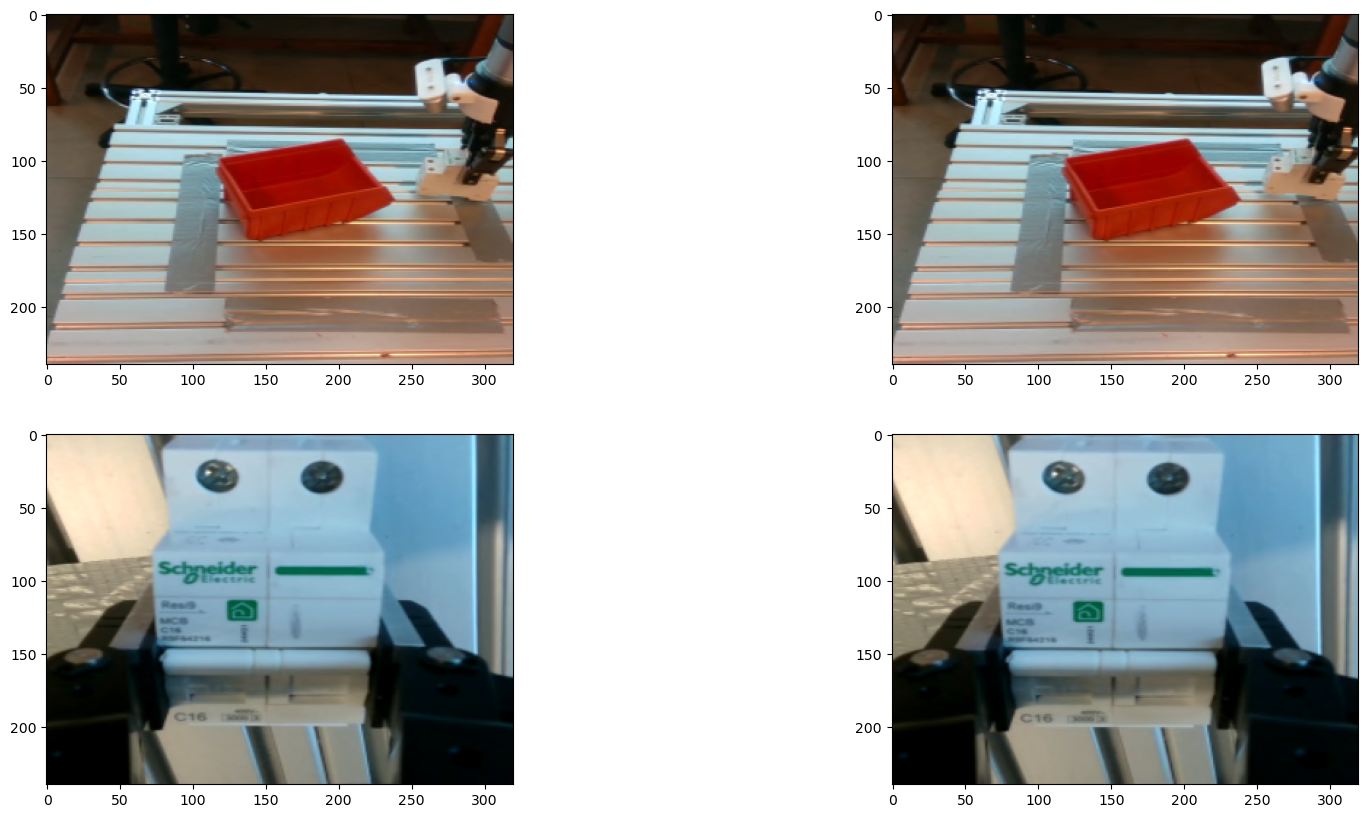

In [4]:
# display a batch of images

import matplotlib.pyplot as plt
import numpy as np

batch = dataset[3]
obs = batch["obs"]
action = batch["action"]
for k,v in obs.items():
    print(k, v.shape)
fig, axs = plt.subplots(2, n_obs_steps, figsize=(20, 10))

for i in range(n_obs_steps):
    img = obs["camera_0"][i].permute(1, 2, 0).numpy()
    axs[0, i].imshow(img)

    img = obs["camera_1"][i].permute(1, 2, 0).numpy()
    axs[1, i].imshow(img)



In [6]:
from diffusion_policy.model.vision.timm_model import TimmRGBModel

model = TimmRGBModel("resnet34.a1_in1k", (3, 64, 64),feature_aggregation="avg")

import torch
b = torch.zeros(6,3,64,64)
f = model(b)
print(f.shape)


torch.Size([6, 512])


In [15]:
#model = TimmRGBModel("vit_base_patch16_clip_224.openai", (3, 224, 224),feature_aggregation="avg")
model = TimmRGBModel("vit_small_patch16_224.dino", (224, 224),feature_aggregation="avg")
import torch
b = torch.zeros(6,3,224,224)
f = model(b)
print(f.shape)

vit will use the CLS token. feature_aggregation (avg) is ignored!


torch.Size([6, 384])


In [8]:
from diffusion_policy.model.vision.model_getter import get_resnet
model = get_resnet("resnet18","IMAGENET1K_V1")
f = model(b)
print(f.shape)

torch.Size([6, 512])


In [9]:
# build a multiImageObsencoder using the timm model
from diffusion_policy.model.vision.multi_image_obs_encoder import MultiImageObsEncoder
shape_meta = {
    "obs": {
        "camera_0": {
            "shape": [3, 240, 320],
            "type": "rgb"
        },
        "camera_1": {
            "shape": [3, 240, 320],
            "type": "rgb"
        },
        "robot_eef_pose_6d_rot": {
            "shape": [9],
            "type": "low_dim"
        },
        "gripper_width" :{
            "shape": [1],
            "type": "low_dim",
        }
    },
    "action": {
        "shape": [10]
    }
}
encoder = MultiImageObsEncoder(shape_meta,model,(240,320),crop_shape=(224,224))





In [17]:
sample_obs_dict = {
    "camera_0": torch.zeros(6,3,240,320),
    "camera_1": torch.zeros(6,3,240,320),
    "robot_eef_pose_6d_rot": torch.zeros(6,9),
    "gripper_width": torch.zeros(6,1)
}
f = encoder(sample_obs_dict)
print(f.shape)

torch.Size([6, 1034])


In [20]:
print(encoder.output_shape())

torch.Size([1034])
